In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import numba

from yahist import Hist2D, Hist1D
import uproot_methods
import toolz
from tqdm.auto import tqdm

import utils

In [4]:
utils.set_plotting_style()

gdf = utils.get_geometry_df("/home/users/namin/2019/scouting/repo/geometry/tracker_geometry_data2018.root")

## Make faces and dump

In [378]:
%%time
allfaces = []
# for irow,entry in gdf.query("0<translation_z<5").iterrows():
for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0
    newshape[1] += 0
    newshape[2] += 0.05
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    faces = []
    for i in [0,1,2]:
        for j in [0,1]:
            steps = np.roll(np.array([
                [j,0,0],
                [j,1,0],
                [j,0,1],
                [j,1,1],
            ])*2-1,i)
            face = np.einsum("ij,kj->ik",shape*steps,matrix)+translation
            faces.append(face)
    allfaces.append(np.array(faces))
allfaces = np.array(allfaces)
gdf["faces"] = [f for f in allfaces]
print(allfaces.shape)

(1856, 6, 4, 3)
CPU times: user 1.13 s, sys: 19 ms, total: 1.15 s
Wall time: 1.16 s


In [398]:
# dump to c++ file

buff = ""
# buff += ("const std::vector<std::vector<std::vector<TVector3> > > modules = {\n")
buff += "const unsigned int NMODULES = {};\n".format(len(allfaces))
buff += "const unsigned int NFACES = {};\n".format(6)
buff += "const unsigned int NCORNERS = {};\n".format(4)
buff += "const TVector3 module_faces[NMODULES][NFACES][NCORNERS] = {\n"

def pointstr(p):
    return "TVector3({:.6f},{:.6f},{:.6f})".format(*p)

mstrs = []
for imodule,module in enumerate(allfaces):
    strs = []
    for face in module:
        strs.append(
            "      {{ {} }}".format(", ".join(list(map(pointstr,face))))
        )
    mstrs.append(
        "    {{\n{}\n    }}".format(",\n".join(strs))
    )
buff += (
    ",\n".join(mstrs)
)
buff += ("\n};")
with open("pixel_module_faces_2018.h","w") as fh:
    fh.write(buff)

## Computation functions

In [271]:
@numba.njit()
def vec_norm(v):
    x = 0.
    for e in v:
        x += e*e
    return x**0.5

@numba.njit()
def unit_vec(v):
    return v/vec_norm(v)

In [272]:
# https://stackoverflow.com/questions/24828653/calculate-if-a-rectangle-is-intersected-by-a-ray-in-c-3d?rq=1

@numba.njit()
def cross_product(v1,v2):
    out = np.array([0.,0.,0.])
    out[0] = v1[1]*v2[2] - v1[2]*v2[1]
    out[1] = v1[2]*v2[0] - v1[0]*v2[2]
    out[2] = v1[0]*v2[1] - v1[1]*v2[0]
    return out


@numba.njit()
def is_inside(vertices, rayorig, raydir):
    v = vertices
    raydirunit = unit_vec(raydir)

    normal = cross_product(v[1]-v[0],v[3]-v[0])
    if np.abs(normal).sum() < 1e-6:
        normal = cross_product(v[2]-v[1],v[3]-v[0])
    normalunit = unit_vec(normal)

    h = np.dot(rayorig - v[0],normalunit)
    dproj = np.dot(raydirunit,-normalunit)
    scale = h/dproj
    if scale < 0: return False
    p = rayorig + raydirunit*scale

    a0 = vec_norm(cross_product(v[0]-p, v[1]-p))
    a1 = vec_norm(cross_product(v[1]-p, v[2]-p))
    a2 = vec_norm(cross_product(v[2]-p, v[3]-p))
    a3 = vec_norm(cross_product(v[3]-p, v[0]-p))
    trec = vec_norm(normal)

    inside = 0.5*(a0+a1+a2+a3) <= trec
    return inside

In [273]:
@numba.njit()
def num_crosses(rayorig, raydir):
    num = 0
    for imodule in range(len(allfaces)):
        module = allfaces[imodule]
        nfacesinside = 0
        for iface in range(len(module)):
            face = module[iface]
            inside = is_inside(
                vertices = face,
                rayorig = rayorig,
                raydir = raydir,
            )
            if inside:
                nfacesinside += 1
                if nfacesinside >= 2:
                    num += 1
                    break
    return num

def num_crosses_wrapper(x):
    raydir = x
    rayorig = np.array([0.,0,0])
    return num_crosses(rayorig,raydir)

def num_crosses_wrapper_many(xs):
    out = []
    rayorig = np.array([0.,0,0])
    for raydir in xs:
        out.append(num_crosses(rayorig,raydir))
    return out

def num_crosses_wrapper_many_unfold(x):
    out = []
    for px,py,pz,vx,vy,vz in x:
        rayorig = np.array([px,py,pz])
        raydir = np.array([vx,vy,vz])
        out.append(num_crosses(rayorig,raydir))
    return out

In [274]:
%%time
raydir = np.array([1,0.15,0.0])
rayorig = np.array([3.,3,2])

num_crosses(rayorig,raydir)

CPU times: user 2.83 s, sys: 34 ms, total: 2.86 s
Wall time: 3.52 s


3

In [275]:
%%time
num_crosses(rayorig,raydir)

CPU times: user 20 ms, sys: 1 ms, total: 21 ms
Wall time: 20.5 ms


3

## Visualization

Text(0, 0.5, 'y (cm)')

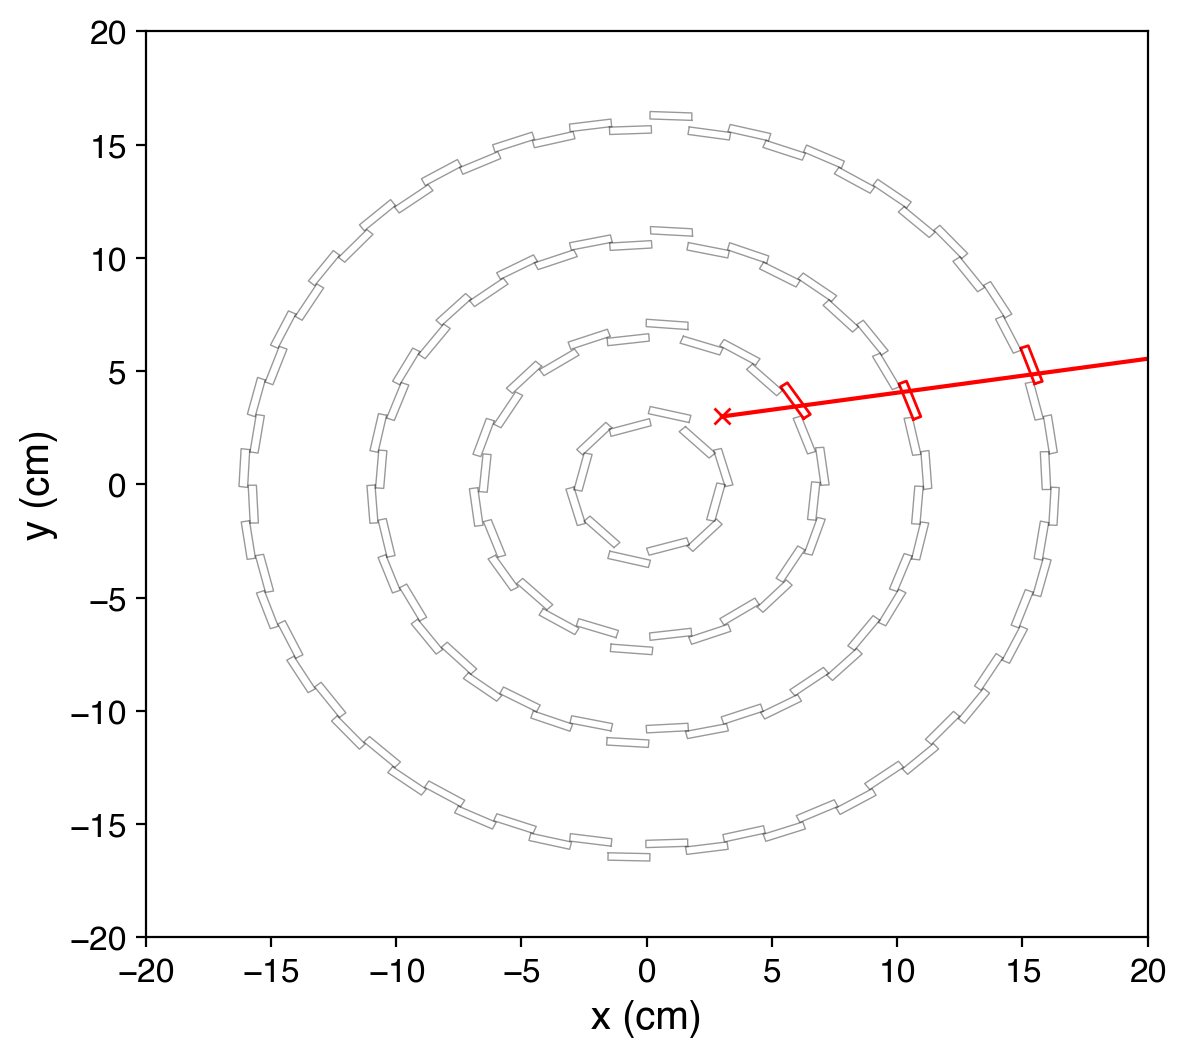

In [513]:
# from ipywidgets import interact
# @interact
# def plot(rx=1.0,ry=1.8,rz=0.0):

rayorig = np.array([3.0,3,2])
raydir = np.array([1,0.15,0.0])

# rayorig = np.array([-3.0,-3,2])
# raydir = np.array([1,4.15,0.0])

fig,ax = plt.subplots(1,1,figsize=(6,6))

step_directions = np.array([
    [0,0,0],[0,0,1],[0,1,0],[0,1,1],
    [1,0,0],[1,0,1],[1,1,0],[1,1,1],
])*2-1


raydir *= 15/ np.linalg.norm(raydir)
for irow,entry in gdf.query("0<translation_z<5").iterrows():
#         if irow > 250: break
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    points = shape * step_directions
    points = np.einsum("ij,kj->ik",points,matrix) + translation
    points = points[np.array([6,2,1,5,6])]
    ninside = 0
    inside = False
    for face in entry.faces:
        if is_inside(vertices=face,rayorig=rayorig,raydir=raydir):
            ninside += 1
            if ninside >= 2:
                inside = True
                break
                
    if inside:
        ax.plot(points[:,0],points[:,1],color="r",lw=1.0)
    else:
        ax.plot(points[:,0],points[:,1],color="k",lw=0.5,alpha=0.4)

ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

ax.plot(rayorig[0],rayorig[1],color="r",marker="x")
ax.plot([rayorig[0],rayorig[0]+raydir[0]*8],[rayorig[1],rayorig[1]+raydir[1]*8],color="r")


# ax.axis("off")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

Text(0, 0.5, '$\\rho$ (cm)')

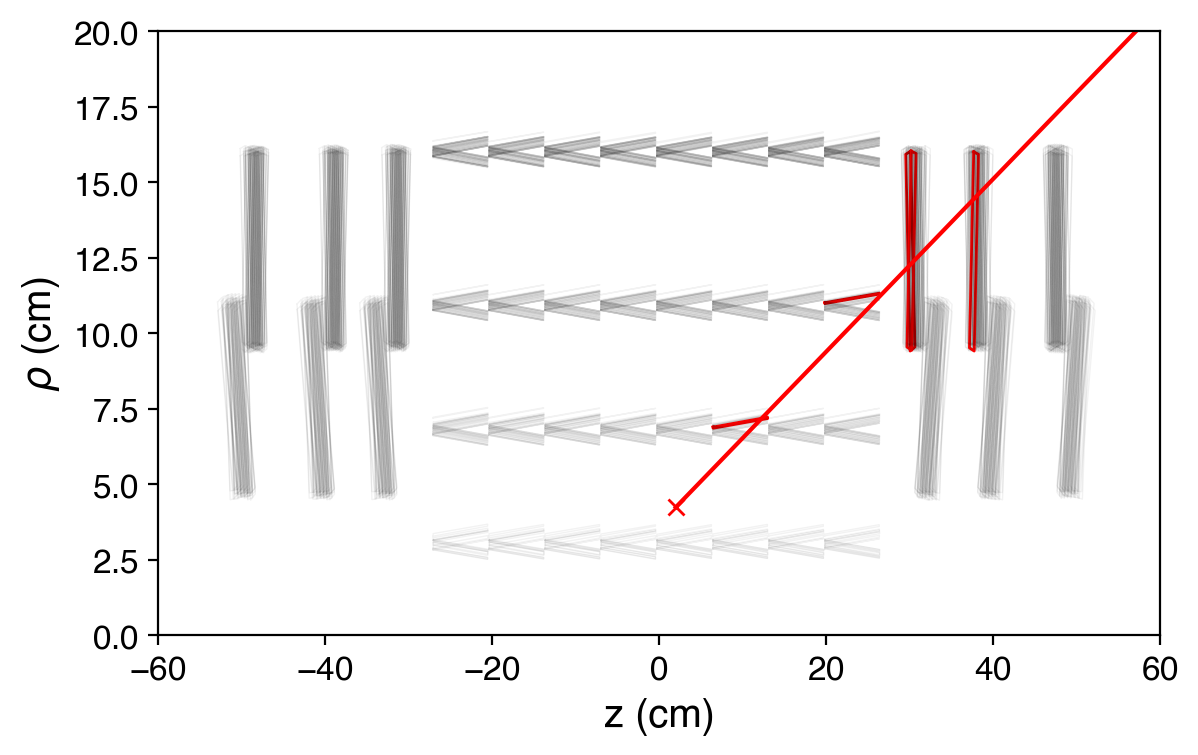

In [515]:
# from ipywidgets import interact
# @interact
# def plot(rx=1.0,ry=1.8,rz=0.0):

rayorig = np.array([3.0,3,2])
raydir = np.array([1,0.15,3.0])

# rayorig = np.array([-3.0,-3,2])
# raydir = np.array([1,4.15,0.0])

fig,ax = plt.subplots(1,1,figsize=(6,4))

step_directions = np.array([
    [0,0,0],[0,0,1],[0,1,0],[0,1,1],
    [1,0,0],[1,0,1],[1,1,0],[1,1,1],
])*2-1

# rayorig = args[sel][1][:3]
# raydir = args[sel][1][3:]

raydir *= 15/ np.linalg.norm(raydir)
# for irow,entry in gdf.query("0<translation_z<5").iterrows():
for irow,entry in gdf.iterrows():
#         if irow > 250: break
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    points = shape * step_directions
    points = np.einsum("ij,kj->ik",points,matrix) + translation
    points = points[np.array([6,2,1,5,6])]
    ninside = 0
    inside = False
    for face in entry.faces:
        if is_inside(vertices=face,rayorig=rayorig,raydir=raydir):
            ninside += 1
            if ninside >= 2:
                inside = True
                break
#     if inside:
#         print(irow)
#         print(entry.faces)
#         print(rayorig)
#         print(raydir)
    rho = np.hypot(points[:,0],points[:,1])
    if inside:
        ax.plot(points[:,2],rho,color="r",lw=1.0)
    else:
        ax.plot(points[:,2],rho,color="k",lw=0.5,alpha=0.05)

ax.set_xlim([-60,60])
ax.set_ylim([0,20])

raydirrho = np.hypot(raydir[0]-rayorig[0],raydir[1]-rayorig[1])
rayorigrho = np.hypot(rayorig[0],rayorig[1])
ax.plot(rayorig[2],rayorigrho,color="r",marker="x")
ax.plot([rayorig[2],rayorig[2]+raydir[2]*8/2**0.5],[rayorigrho,rayorigrho+raydirrho*8],color="r")


# ax.axis("off")
ax.set_xlabel("z (cm)")
ax.set_ylabel(r"$\rho$ (cm)")

## Comparison plots for expected pixel hits

In [279]:
from dask import delayed
from dask.distributed import Client
client = Client("uaf-10.t2.ucsd.edu:50123")
client

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 20 Cores: 20 Memory: 100.00 GB


In [280]:
etabins = np.linspace(-2.4,2.4,251)
phibins = np.linspace(-np.pi,np.pi,251)

etabincenters = 0.5*(etabins[:-1]+etabins[1:])
phibincenters = 0.5*(phibins[:-1]+phibins[1:])

etas = np.tile(etabincenters, len(phibincenters))
phis = np.repeat(phibincenters, len(etabincenters))

p4s = uproot_methods.TLorentzVectorArray.from_ptetaphim(
    np.ones(len(etas))*50.,etas,phis,np.zeros(len(etas))
)
vecs = p4s.p3

args = np.c_[vecs.x,vecs.y,vecs.z]
results = sum(
    client.gather(
        client.map(
            num_crosses_wrapper_many,list(toolz.partition_all(500,args))
        )
    )
,[])

h = Hist2D(np.c_[etas,phis], bins=[etabins,phibins], weights=np.array(results))

Text(0, 0.5, '$\\phi$')

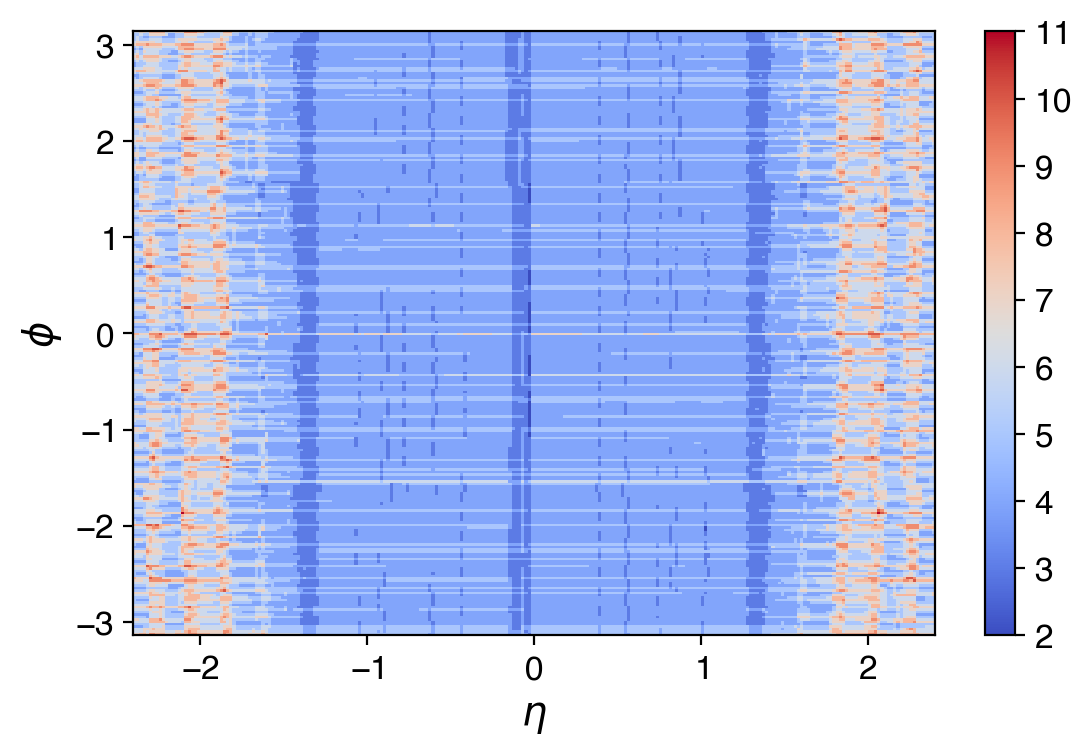

In [281]:
fig, ax = plt.subplots()
h.plot(ax=ax,cmap="coolwarm")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

In [282]:
df_data = pd.read_pickle("data/df_data.pkl")
df_mc = pd.read_pickle("data/df_mc.pkl")

Text(0, 0.5, '$\\phi$')

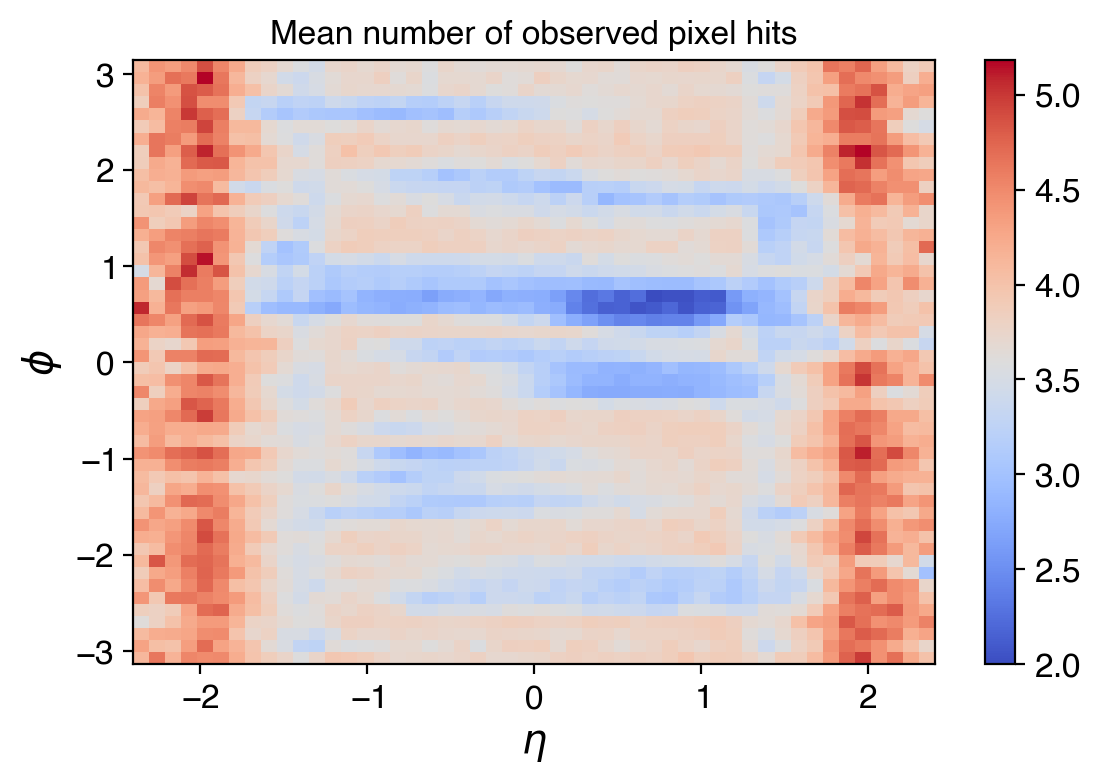

In [337]:
df = df_data
# df = df_mc
hnum = Hist2D(np.c_[df["Muon1_eta"],df["Muon1_phi"]], bins=[np.linspace(-2.4,2.4,51),np.linspace(-np.pi,np.pi,51)], weights=df["Muon1_nValidPixelHits"])
hden = Hist2D(np.c_[df["Muon1_eta"],df["Muon1_phi"]], bins=[np.linspace(-2.4,2.4,51),np.linspace(-np.pi,np.pi,51)])
fig, ax = plt.subplots()
(hnum/hden).plot(ax=ax,cmap="coolwarm")
ax.set_title("Mean number of observed pixel hits")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

In [311]:
# df = df_data.head(30000)
df = df_mc.head(30000)

In [312]:
dvx = df["DV_x"]#-df["BS_x"]
dvy = df["DV_y"]#-df["BS_y"]
dvz = df["DV_z"]#-df["BS_z"]

mu1x = df.vec.mu1.x
mu1y = df.vec.mu1.y
mu1z = df.vec.mu1.z

# args = np.c_[dvx,dvy,dvz,mu1x,mu1y,mu1z]
args = np.c_[dvx,dvy,dvz,mu1x,mu1y,mu1z]
# args

ncrosses = np.array(sum(
    client.gather(
        client.map(
            num_crosses_wrapper_many_unfold,list(toolz.partition_all(500,args))
        )
    )
,[]))

(df["Muon1_nValidPixelHits"]==ncrosses).mean()

0.554

In [313]:
sel = (
    (np.abs(df["Muon1_eta"])<0.2)
 & (np.abs(df["DV_rho"])>8.)
 & (np.abs(df["DV_z"])<2.)
#  (np.abs(df["DV_rho"])>10.)
)
(df["Muon1_nValidPixelHits"]==ncrosses)[sel].mean()

0.8171641791044776

Text(0, 0.5, 'expected')

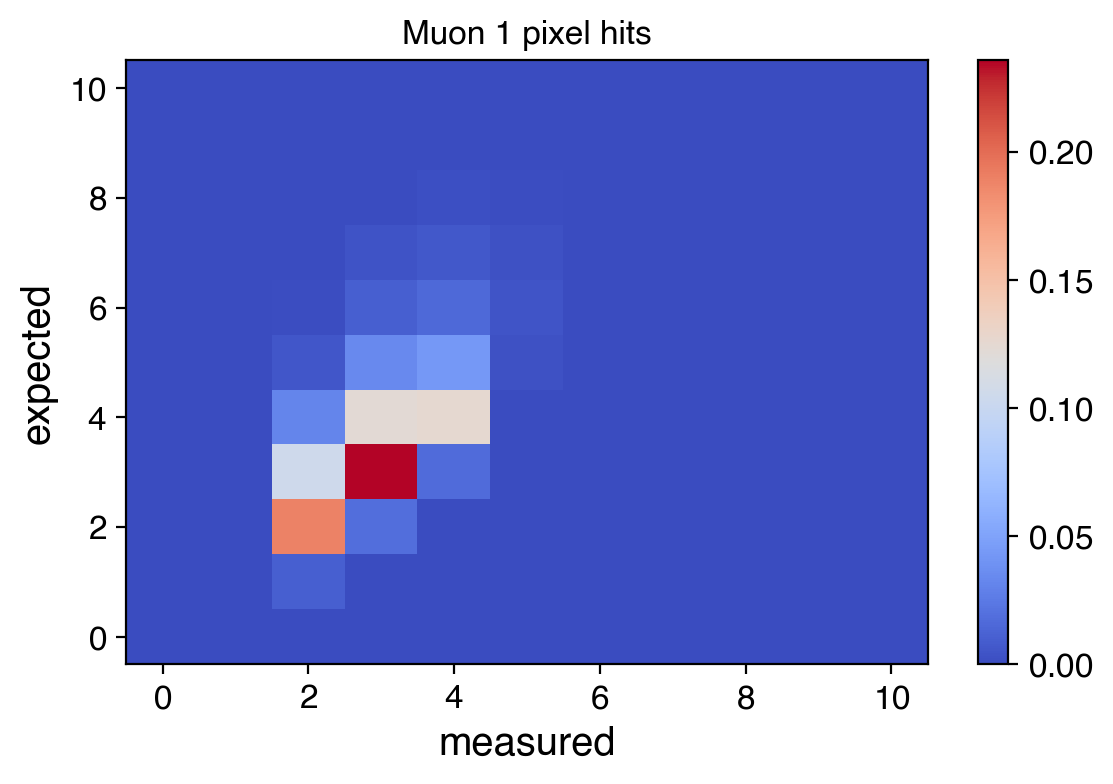

In [321]:
fig, ax = plt.subplots()
Hist2D(np.c_[df["Muon1_nValidPixelHits"],ncrosses],bins=np.arange(12)-0.5).normalize().plot(ax=ax,cmap="coolwarm")
# Hist2D(np.c_[df["Muon1_nValidPixelHits"][sel],ncrosses[sel]],bins=np.arange(12)-0.5).plot(ax=ax,cmap="cividis")
ax.set_title("Muon 1 pixel hits")
ax.set_xlabel("measured")
ax.set_ylabel("expected")
# ncrosses

Text(0.5, 1.0, 'Muon 1 expected - measured')

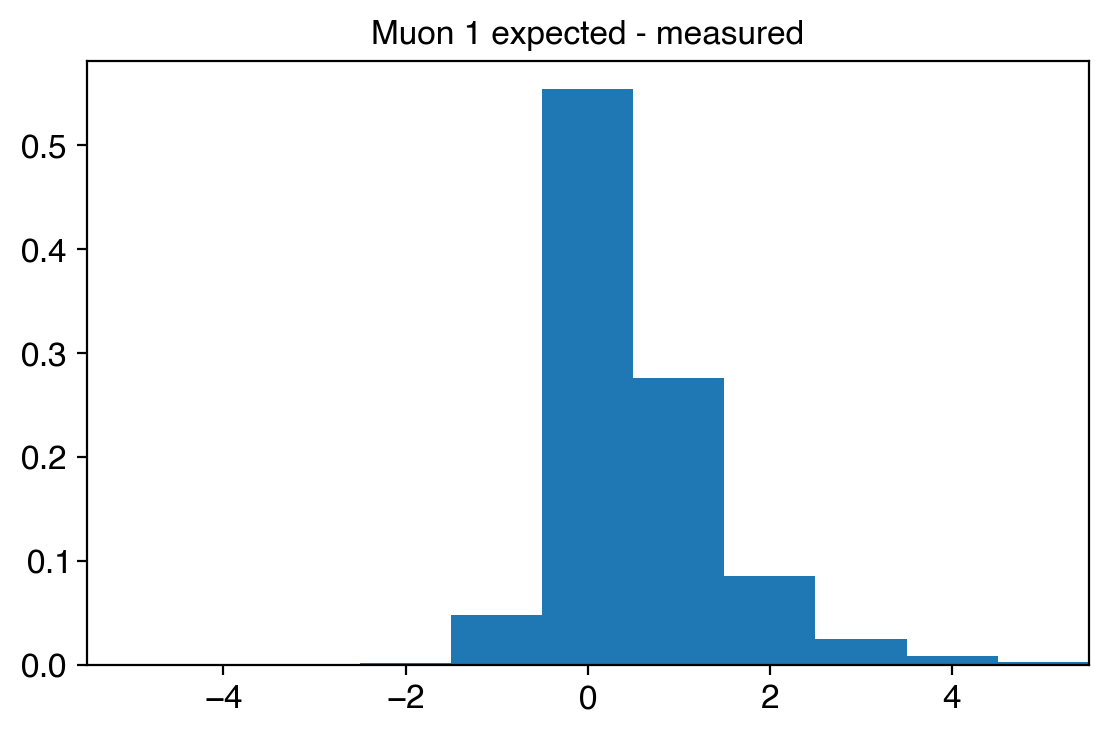

In [318]:
fig, ax = plt.subplots()
Hist1D(ncrosses-df["Muon1_nValidPixelHits"],bins=np.arange(12)-5.5).normalize().plot(ax=ax)
ax.set_title("Muon 1 expected - measured")

## Inside pixel modules?

In [401]:
%%time
vshape = []
vtranslation = []
vmatrix = []
for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    vshape.append(shape)
    vtranslation.append(translation)
    vmatrix.append(matrix.T)

CPU times: user 399 ms, sys: 13 ms, total: 412 ms
Wall time: 419 ms


In [492]:
# to check for containment of a point inside a pixel module
# we transform the point with the inverse transformation of the pixel module.
# The module is then a box around the origin with half-widths given by `shape`
# We check that each coordinate of the point is within the half width
# --> (np.abs(np.dot(matrix, point-translation))<shape).sum() == 3
# below is a more vanilla implementation with hardcoded matrix multiplication
    
@numba.njit()
def f(point, flatmatrix, translation, shape):
    shifted = np.array([0.,0.,0.])
    for i in range(3):
        shifted[i] = point[i]-translation[i]
    for i in range(3):
        if abs(flatmatrix[3*i]*shifted[0] + flatmatrix[3*i+1]*shifted[1] + flatmatrix[3*i+2]*shifted[2]) > shape[i]: return False
    return True

(-15.0, 15.0)

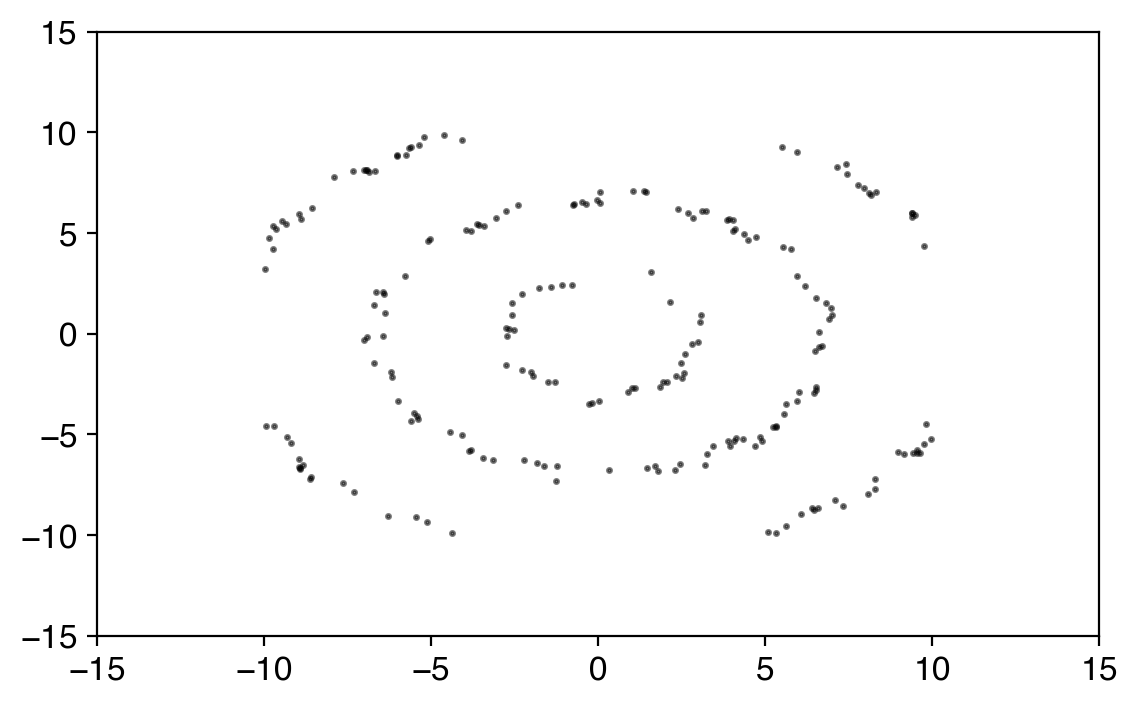

In [517]:
fig, ax = plt.subplots()
for _ in tqdm(range(2500)):
    point = np.array([np.random.uniform(-10,10), np.random.uniform(-10,10), 2.0])
#     point = np.array([np.random.uniform(6.0,7.8), np.random.uniform(-1.5,3.8), 2.0])

    inside = False
    for imodule, (shape, translation, matrix) in enumerate(zip(vshape, vtranslation, vmatrix)):
        check = f(point, matrix.flatten(), translation, shape)
        if check:
            inside = True
            break
    if inside:
        ax.plot(point[0],point[1], marker="o", color="k", ms=1.5, alpha=0.5)
    
ax.set_xlim(-15.,15.)
ax.set_ylim(-15.,15.)

In [510]:
# dump to c++ file

buff = ""
buff += "// First 9 elements are rotation matrix, then 3 for translation, then 3 for shape\n"
buff += "// Test if a point is contained in a module with\n"
buff += """
/*
def f(point, arr):
    shifted = np.array([0.,0.,0.])
    for i in range(3):
        shifted[0] = point[0]-arr[i+9]
    for i in range(3):
        if abs(arr[3*i]*shifted[0] + arr[3*i+1]*shifted[1] + arr[3*i+2]*shifted[2]) > arr[i+12]: return False
    return True
*/\n
"""
buff += "const unsigned int NMODULES = {};\n".format(len(allfaces))
buff += "float module_volumes[NMODULES][15] = {\n"

mstrs = []
for imodule, (shape, translation, matrix) in enumerate(zip(vshape, vtranslation, vmatrix)):
    mstrs.append(("  {{ "
     "{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},"
     "{:.7f},{:.7f},{:.7f},"
     "{:.7f},{:.7f},{:.7f} "
     "}}").format(*matrix.flatten(), *translation, *shape))
buff += (
    ",\n".join(mstrs)
)
buff += ("\n};")
with open("pixel_module_volumes_2018.h","w") as fh:
    fh.write(buff)